In [1]:
# Mid-fjord (re)circulation
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

/Users/weiyangbao/miniconda3/envs/py37/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
# Find the interface and vertical flux of theta
def Layer(u):
    # Layer interface, zero velocity crossing point
    uzx = u.mean(axis=(0,2)) # Z, X
    X = uzx.shape[1]
    itf = np.empty(X, dtype=int)
    itf[[0,-1]] = 0
    for i in range(1,X-1):
        l = np.where(uzx[:, i] < 0)[-1][0]
        itf[i] = l
    return itf

In [3]:
def transVol(sd):
    state01 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/State700/Hs_' + str(format(sd,'03d')) + '.nc')
    state1 = state01.isel(Y=range(1,10), T=range(40,121))

    u = 0.5 * (state1.U.data[:,:,:,:-1] + state1.U.data[:,:,:,1:])  
    w = 0.5 * (state1.W.data[:,:-1,:,:] + state1.W.data[:,1:,:,:])
    
    Area = np.empty([50, 9]) # Cross Y direction
    Area[:10, :] = 100
    Area[10:20, :] = 200
    Area[20:30, :] = 300
    Area[30:40, :] = 800
    Area[40:, :] = 1600

    f = 3 # Control volume start index near the ice front
    s = 28 # Control volume end index at the sill crest
    
    itf = Layer(u)
    Vx1 = np.empty(s-f+1) # Horizontal volume transport for the upper layer
    Vx2 = np.empty(s-f+1) # Horizontal volume transport for the lower layer
    Vz = np.empty(s-f+1) # Vertical volume transport through the interface
    for i in range(s-f+1):
        it = itf[f:s+1]
        ut = u[:,:,:,f:s+1].mean(0)
        wt = w[:,:,:,f:s+1].mean(0)
        Vx1[i] = np.sum(ut[:it[i],:,i] * Area[:it[i],:])
        Vx2[i] = np.sum(ut[it[i]:,:,i] * Area[it[i]:,:])
        Vz[i] = np.sum(wt[it[i],:,i] * 200 * 200)
        
    return (Vx1, Vx2, Vz)

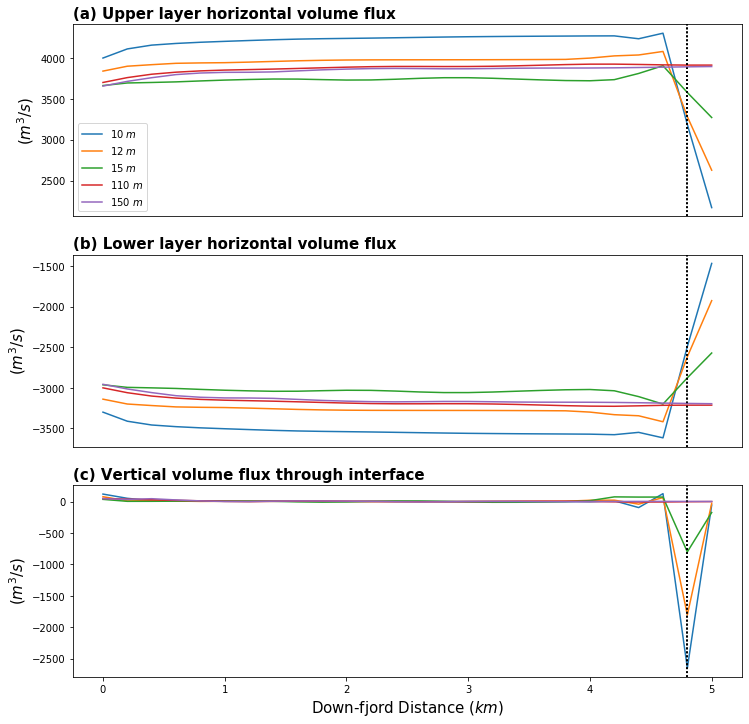

In [14]:
sd = np.array([10, 12, 15, 110, 150]) # Sill depth
files = sorted(glob.glob('/Users/weiyangbao/Documents/Model_outputs/State700/Hs*.nc'))
X = np.arange(26) * 0.2
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(12,12))
for i in range(len(sd)):
    V1, V2, Vz = transVol(sd[i])
    
    ax1.plot(X, V1, label=str(sd[i])+' $m$')
    ax1.axvline(x=X[-2],color='k',linestyle=':')
    ax1.legend(loc = 'best', fontsize = 10)
    ax1.set_ylabel('($m^3/s$)',size = 15)
    ax1.xaxis.set_visible(False) # This erases the y ticks
    ax1.set_title('(a) Upper layer horizontal volume flux', loc='left', size=15, weight='bold')

    ax2.plot(X, V2)
    ax2.axvline(x=X[-2],color='k',linestyle=':')
    ax2.set_ylabel('($m^3/s$)',size = 15)
    ax2.xaxis.set_visible(False) # This erases the y ticks
    ax2.set_title('(b) Lower layer horizontal volume flux', loc='left', size=15, weight='bold')
    
    ax3.plot(X,Vz)
    ax3.axvline(x=X[-2],color='k',linestyle=':')
    ax3.set_ylabel('($m^3/s$)',size = 15)
    ax3.set_xlabel('Down-fjord distance ($km$)', size = 15)
    ax3.set_title('(c) Vertical volume flux through interface', loc='left', size=15, weight='bold')
    #plt.close()
    #fig.savefig(fig_path + '/q100.png', dpi = 150, bbox_inches='tight'))
    

In [15]:
fig_path = "/Users/weiyangbao/Documents/Jupyter_Figs/Transport/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
fig.savefig(fig_path + '/Recirculation.png', dpi = 150, bbox_inches='tight')